In [2]:
#imports
import gzip
import glob
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.stats import mad_std, sigma_clipped_stats, SigmaClip, sigma_clip
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from photutils import datasets, DAOStarFinder, SkyCircularAperture, aperture_photometry, CircularAperture, CircularAnnulus, Background2D, MedianBackground
from photutils.background import Background2D
from photutils.detection import find_peaks
from photutils.utils import calc_total_error
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
kred=np.load('/users/caganze/research/J1624/data/nirc2_k_band_stacked_reduced.npy')

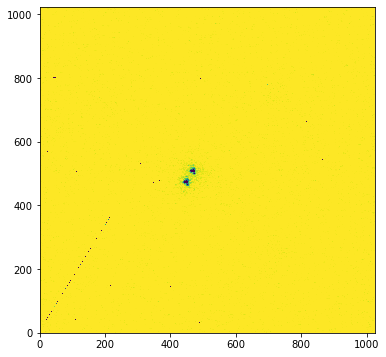

In [8]:
fig, ax=plt.subplots(figsize=(6, 6))
ax.pcolormesh(kred, vmin=0, vmax=1)

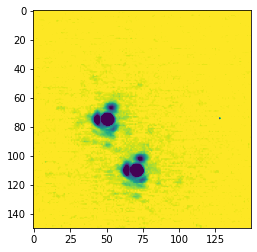

In [20]:
fig, ax=plt.subplots()
cutout =kred[400:550, 400:550]
plt.imshow(cutout, vmin=0, vmax=1)

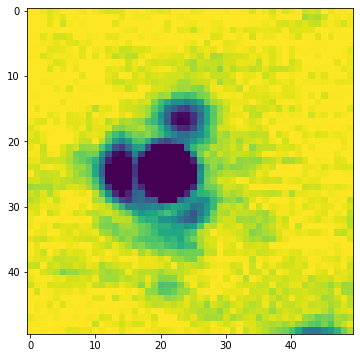

In [66]:
cutoutprim=kred[450:500,  430:480]
fig, ax=plt.subplots(figsize=(6,6))
ax.imshow(cutoutprim, vmin=0, vmax=1)

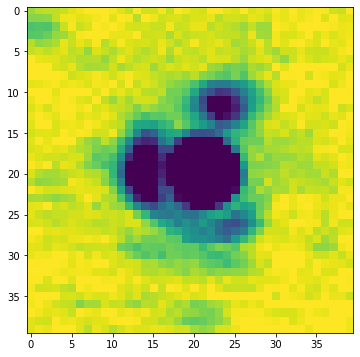

In [103]:
cutoutsec=kred[450+40:540-10,  450:550-60]
fig, ax=plt.subplots(figsize=(6, 6))
plt.imshow(cutoutsec, vmin=0, vmax=1)

In [104]:

# Answer
xx, yy = np.meshgrid(np.arange( 430, 480), np.arange(450, 500))
# Answer
xx2, yy2 = np.meshgrid(np.arange( 450, 550-60), np.arange(450+40, 540-10))

In [109]:
#centroid for the primary

x_center = np.sum(cutoutprim*xx)/np.sum(cutoutprim)
y_center = np.sum(cutoutprim*yy)/np.sum(cutoutprim)


x2_center = np.sum(cutoutsec*xx2)/np.sum(cutoutsec)
y2_center = np.sum(cutoutsec*yy2)/np.sum(cutoutsec)

print(x_center, y_center, x2_center, y2_center)

455.1876651210996 474.17781925460724 469.3220336724745 509.5605972908248


[(400.0, 525.0), (400.0, 550.0)]

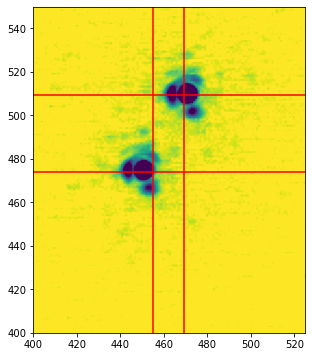

In [111]:
fig, ax=plt.subplots(figsize=(6, 6))
plt.imshow(kred, vmin=0, vmax=1)
plt.axvline(x_center, color='r')
plt.axhline(y_center, color='r')

plt.axvline(x2_center, color='r')
plt.axhline(y2_center, color='r')
ax.set(xlim=[400, 525], ylim=[400, 550])

In [112]:
def ap_phot(img,xc,yc,ap):
    pos = (xc,yc)
    aperture = CircularAperture(pos,r=ap)
    rin = 20
    rout = 24
    bkgap = CircularAnnulus(pos, r_in=rin, r_out=rout)
    apers = [aperture,bkgap]
    phottab = Table(aperture_photometry(img, apers, method='exact')).to_pandas()
    fsb = phottab['aperture_sum_0'].values
    fbkg = phottab['aperture_sum_1'].values
    sflux = (fsb/aperture.area - fbkg/bkgap.area) * aperture.area
    return fsb[0]

def diff_phot(f1,f2):
    deltamag = -2.5*np.log10(f1/f2)
    return deltamag

def get_asep(x1,y1,x2,y2):
    asep = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return asep

In [113]:
ps = [cutoutsec, cutoutprim]
#ps = [cutout0, cutout1, cutout2, cutout3]
nim = len(ps)

df = pd.DataFrame(columns=['img','min','max','median','std'])
df['img'] = [obs.loc[i,'filename'].split('/')[-1] for i in range(nim)]
df['date'] = [obs.loc[i,'date'] for i in range(nim)]
df['filter'] = [obs.loc[i,'filter'] for i in range(nim)]
df['min'] = [ps[i].min() for i in range(nim)]
df['max'] = [ps[i].max() for i in range(nim)]
df['median'] = [np.median(ps[i]) for i in range(nim)]
df['std'] = [np.std(ps[i]) for i in range(nim)]

df

NameError: name 'obs' is not defined

In [ ]:
for i in range(nim):
    #daofind = DAOStarFinder(fwhm=5.0, threshold=0.5*np.std(ps[i]))
    daofind = DAOStarFinder(fwhm=5.0, threshold=0.5*np.std(ps[i]))
    xysources = daofind(ps[i]).to_pandas()
    phot1 = ap_phot(ps[i],xysources.loc[0,'xcentroid'],xysources.loc[0,'ycentroid'],ap1)
    phot2 = ap_phot(ps[i],xysources.loc[1,'xcentroid'],xysources.loc[1,'ycentroid'],ap2)
    xysources['phot1'] = phot1
    xysources['phot2'] = phot2
    deltamag = diff_phot(phot2,phot1)
    df.loc[i,'deltamag'] = deltamag
    df.loc[i,'xc1'] = xysources.loc[0,'xcentroid']
    df.loc[i,'yc1'] = xysources.loc[0,'ycentroid']
    df.loc[i,'xc2'] = xysources.loc[1,'xcentroid']
    df.loc[i,'yc2'] = xysources.loc[1,'ycentroid']
    df.loc[i,'imsep'] = get_asep(df.loc[i,'xc1'],df.loc[i,'yc1'],df.loc[i,'xc2'],df.loc[i,'yc2'])
    df['asep'] = df['imsep'] * hdr['PIXSCALE'] #arcsec
    df.to_csv('2M2126+7617_NIRC2_20150723.csv')
    #df.to_csv('2M2126+7617_NIRC2_20130923.csv')